In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from equipy.fairness import MultiWasserstein
from equipy.metrics import unfairness, performance
from sklearn.metrics import log_loss, mean_squared_error

In [18]:
from aif360.sklearn.datasets import fetch_compas

data = fetch_compas(
    subset="all",
    data_home="./data/aif360_data",   # any writable folder
    cache=True,
    binary_race=False,           # set True if you want only White/Black
    dropna=True
)

X = data.X          # pandas DataFrame
y = data.y          # pandas Series (0/1)

# Remove index levels named sex/race without changing row order
if isinstance(X.index, pd.MultiIndex) and any(n in X.index.names for n in ["sex"]):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

# Sensitive attributes are in X by default in usecols, including 'sex' and 'race'
atr = "sex"
S = X[[atr]].copy()
print(X.shape, y.shape, S.value_counts().head())

(6167, 10) (6167,) sex   
Male      4994
Female    1173
Name: count, dtype: int64


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


y = np.where(y == 'Recidivated', 1, 0)

# X, y, S already defined from fetch_compas(...)
# Make an intersectional key for stratified splits (keeps all group modalities present)
joint = (S[atr].astype(str)).to_numpy()

# ---- 60/20/20 split: train / calib / test ----
idx = np.arange(len(X))

idx_train, idx_tmp = train_test_split(
    idx,
    test_size=0.4,
    random_state=0,
    stratify=joint
)

# stratify for the remaining indices using their joint labels
joint_tmp = joint[idx_tmp]
idx_calib, idx_test = train_test_split(
    idx_tmp,
    test_size=0.5,   # half of 0.4 => 0.2 each
    random_state=0,
    stratify=joint_tmp
)

# Slice
X_train, y_train, S_train = X.iloc[idx_train].copy(), y[idx_train].copy(), S.iloc[idx_train].copy()
X_calib, y_calib, S_calib = X.iloc[idx_calib].copy(), y[idx_calib].copy(), S.iloc[idx_calib].copy()
X_test,  y_test,  S_test  = X.iloc[idx_test].copy(),  y[idx_test].copy(),  S.iloc[idx_test].copy()

# Optional: drop sensitive cols from features (common for fairness post-processing)
X_train_nos = X_train.drop(columns=[atr], errors="ignore")
X_calib_nos = X_calib.drop(columns=[atr], errors="ignore")
X_test_nos  = X_test.drop(columns=[atr], errors="ignore")

print("Shapes:")
print("train:", X_train.shape, y_train.shape, S_train.shape)
print("calib:", X_calib.shape, y_calib.shape, S_calib.shape)
print("test :", X_test.shape,  y_test.shape,  S_test.shape)

print("\nGroup counts (train):")
print((S_train[atr].astype(str)).value_counts())

print("\nGroup counts (calib):")
print((S_calib[atr].astype(str)).value_counts())

print("\nGroup counts (test):")
print((S_test[atr].astype(str)).value_counts())

Shapes:
train: (3700, 10) (3700,) (3700, 1)
calib: (1233, 10) (1233,) (1233, 1)
test : (1234, 10) (1234,) (1234, 1)

Group counts (train):
sex
Male      2996
Female     704
Name: count, dtype: int64

Group counts (calib):
sex
Male      999
Female    234
Name: count, dtype: int64

Group counts (test):
sex
Male      999
Female    235
Name: count, dtype: int64


In [20]:
optimized_parameters = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "seed": 2,
    "verbosity": -1,
    "force_col_wise": True,  # often faster on wide-ish tabular data
    "num_threads": 32,        # set to your physical cores
}

train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
model = lgb.train(train_set=train_data, params=optimized_parameters, num_boost_round=500)

In [21]:
p_test = model.predict(X_test)
p_calib = model.predict(X_calib)

In [22]:
p_test

array([0.30619695, 0.26599158, 0.62497257, ..., 0.4090501 , 0.05284116,
       0.61929392], shape=(1234,))

In [23]:
def sk_log_loss_binary(y_true, p_score, eps=1e-15, labels=(0, 1)):
    """
    y_true: array-like of shape (n,), values in {0,1}
    p_score: array-like of shape (n,), predicted P(Y=1|x)
    """
    y = np.asarray(y_true).astype(int)
    p = np.asarray(p_score, dtype=float)
    p = np.clip(p, eps, 1 - eps)
    # sklearn expects either (n,) for binary prob of class 1 OR (n,2) with probs for both classes
    return float(log_loss(y, p, labels=list(labels)))

sk_log_loss_binary(y_test, p_test), unfairness(p_test, S_test)


(0.6731923280432365, np.float64(0.1954873826325898))

In [24]:
wasserstein = MultiWasserstein(sigma=1e-4)
wasserstein.fit(y=p_calib, sensitive_features=S_calib)

In [25]:
p_test_fair = wasserstein.transform(y=p_test, sensitive_features=S_test)

In [26]:
sk_log_loss_binary(y_test, p_test_fair), unfairness(p_test_fair, S_test)

(0.6759141792542949, np.float64(0.08386123350007124))

In [27]:
from sinkhorn_fairness import monge_maps_fit, apply_fair_maps_to_test_logits, create_marginal_masks, apply_map_1d, hist_on_grid

In [28]:
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log1p(-p)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z_calib = logit(p_calib)
z_test  = logit(p_test)

# fit OT maps on logits
maps, grid = monge_maps_fit(
    S_calib=S_calib,
    p_calib=z_calib,
    sinkhorn_reg=1e-2,        # logits often need larger reg
    sinkhorn_tol=1e-10,
    sinkhorn_maxiter=50_000,
    pad=1e-5,
    cost='l2'
)

z_fair = apply_fair_maps_to_test_logits(
    p_test=z_test,
    S_test=S_test,
    grid=grid,
    maps=maps,
)

p_fair_sink = sigmoid(z_fair)

In [29]:
sk_log_loss_binary(y_test, p_fair_sink), unfairness(p_fair_sink, S_test)

(0.6766417860567127, np.float64(0.07518094239567896))

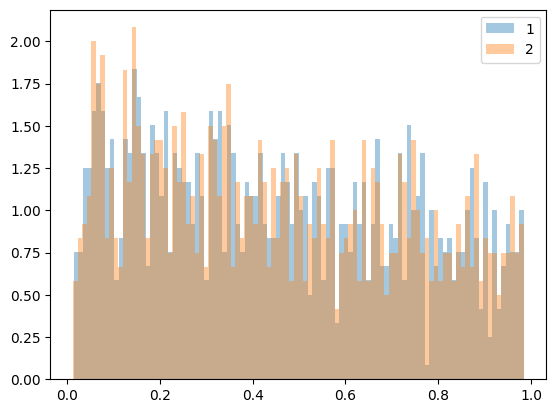

In [30]:
from matplotlib import pyplot as plt

plt.figure()
# plt.hist(predictions_test_fair, bins=100, density=True, alpha=0.4, label="plt.hist density")
plt.hist(p_test_fair, bins=100, density=True, alpha=0.4, label="1")
plt.hist(p_fair_sink, bins=100, density=True, alpha=0.4, label="2")
plt.legend()
plt.show()

In [31]:
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(S_test.columns)
    y_fair = wasserstein.transform(
        y=p_test,
        sensitive_features=S_test,
        epsilon=eps,
    )

    # "risk" / performance (use your paper's metric if different)
    mse = log_loss(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results = pd.DataFrame(rows)
print(results)

    epsilon       mse  unfairness
0       0.0  0.675914    0.083861
1       0.1  0.675147    0.091473
2       0.2  0.674492    0.100520
3       0.3  0.673948    0.108732
4       0.4  0.673513    0.119128
5       0.5  0.673186    0.129806
6       0.6  0.672968    0.141587
7       0.7  0.672858    0.153534
8       0.8  0.672857    0.166763
9       0.9  0.672968    0.181381
10      1.0  0.673192    0.195487


In [32]:
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(S_test.columns)
    z_calib = logit(p_calib)
    z_test  = logit(p_test)

    # fit OT maps on logits
    maps, grid = monge_maps_fit(
        S_calib=S_calib,
        p_calib=z_calib,
        sinkhorn_reg=1e-1,        # logits often need larger reg
        sinkhorn_tol=1e-12,
        sinkhorn_maxiter=50_000,
        pad=1e-5,
        )

    z_fair = apply_fair_maps_to_test_logits(
        p_test=z_test,
        S_test=S_test,
        grid=grid,
        maps=maps,
        alpha=e,
    )

    y_fair = sigmoid(z_fair)

    # "risk" / performance (use your paper's metric if different)
    mse = log_loss(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results_sink = pd.DataFrame(rows)
print(results_sink)

    epsilon       mse  unfairness
0       0.0  0.650006    0.080646
1       0.1  0.651504    0.092283
2       0.2  0.653203    0.105721
3       0.3  0.655095    0.117754
4       0.4  0.657173    0.131710
5       0.5  0.659430    0.141013
6       0.6  0.661860    0.153734
7       0.7  0.664457    0.162766
8       0.8  0.667215    0.173403
9       0.9  0.670129    0.184635
10      1.0  0.673192    0.195487


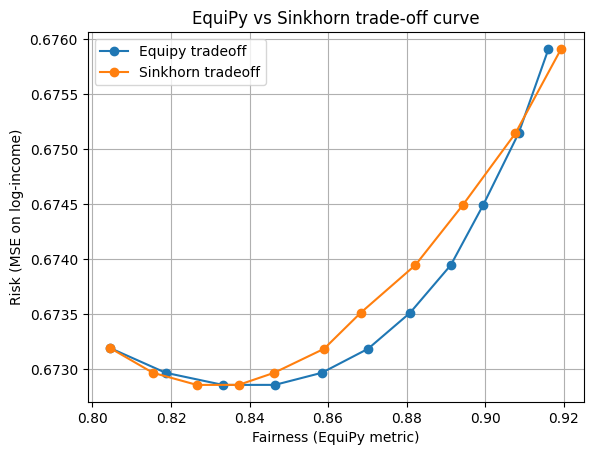


Baseline:
{'mse': 0.23119939439396273, 'Fairness': np.float64(0.1954873826325898)}


In [33]:
# -------------------------------------------------------
# 6) Simple plot: unfairness vs risk (MSE)
# -------------------------------------------------------
plt.figure()
plt.plot(1 - results["unfairness"], results["mse"], marker="o", label="Equipy tradeoff")
plt.plot(1 - results_sink["unfairness"], results["mse"], marker="o", label="Sinkhorn tradeoff")
plt.xlabel("Fairness (EquiPy metric)")
plt.ylabel("Risk (MSE on log-income)")
plt.title("EquiPy vs Sinkhorn trade-off curve")
plt.grid(True)
plt.legend()
plt.show()

# Baseline check (no post-processing):
baseline_mse = mean_squared_error(y_test, p_test)
baseline_unf = unfairness(y=p_test, sensitive_features=S_test)
print("\nBaseline:")
print({"mse": baseline_mse, "Fairness": baseline_unf})

In [34]:
from fairlearn.datasets import fetch_bank_marketing
import pandas as pd
import numpy as np

b = fetch_bank_marketing(as_frame=True)
X, y = b.data, b.target.astype(int) - 1
S = pd.DataFrame({
    "V1": pd.cut(X["V1"], bins=[-np.inf, 29, 39, 45, 50, 59, np.inf], labels=[0,1,2,3,4,5])
})

In [35]:
S.value_counts()

V1
1     18089
4      7471
2      7401
0      5273
3      5193
5      1784
Name: count, dtype: int64

In [36]:
idx = np.arange(len(X))

idx_train, idx_tmp = train_test_split(
    idx, test_size=0.4, random_state=0, stratify=y.to_numpy()
)
idx_calib, idx_test = train_test_split(
    idx_tmp, test_size=0.5, random_state=0, stratify=y.to_numpy()[idx_tmp]
)

X_train = X.iloc[idx_train].copy()
y_train = y.iloc[idx_train].copy()
S_train = S.iloc[idx_train].copy()

X_calib = X.iloc[idx_calib].copy()
y_calib = y.iloc[idx_calib].copy()
S_calib = S.iloc[idx_calib].copy()

X_test  = X.iloc[idx_test].copy()
y_test  = y.iloc[idx_test].copy()
S_test  = S.iloc[idx_test].copy()

In [37]:
# 3) Train LightGBM (binary)
# -----------------------------
optimized_parameters = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "seed": 1,
    "verbosity": -1,
    "force_col_wise": True,  # often faster on wide-ish tabular data
    "num_threads": 32,        # set to your physical cores
}

train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
model = lgb.train(train_set=train_data, params=optimized_parameters, num_boost_round=500)

In [38]:
p_test = model.predict(X_test)
p_calib = model.predict(X_calib)

In [39]:
def sk_log_loss_binary(y_true, p_score, labels=(0, 1)):
    """
    y_true: array-like of shape (n,), values in {0,1}
    p_score: array-like of shape (n,), predicted P(Y=1|x)
    """
    y = np.asarray(y_true).astype(int)
    p = np.asarray(p_score, dtype=float)
    # sklearn expects either (n,) for binary prob of class 1 OR (n,2) with probs for both classes
    return float(log_loss(y, p, labels=list(labels)))

sk_log_loss_binary(y_test, p_test), unfairness(p_test, S_test)

(0.2054293970593681, np.float64(0.5243003191122071))

In [40]:
wasserstein = MultiWasserstein(sigma=1e-4)
wasserstein.fit(y=p_calib, sensitive_features=S_calib)

In [41]:
p_test_fair = wasserstein.transform(y=p_test, sensitive_features=S_test)
sk_log_loss_binary(y_test, p_test_fair), unfairness(p_test_fair, S_test)

(0.22426008891926882, np.float64(0.1492905975338938))

In [42]:
from sinkhorn_fairness import monge_maps_fit, apply_fair_maps_to_test_logits, create_marginals, fast_bins_choice, make_grid

def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log1p(-p)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z_calib = logit(p_calib)
z_test  = logit(p_test)

# fit OT maps on logits
maps, grid = monge_maps_fit(
    S_calib=S_calib,
    p_calib=z_calib,
    sinkhorn_reg=1e-3,        # logits often need larger reg
    sinkhorn_tol=1e-10,
    sinkhorn_maxiter=50_000,
    pad=1e-6,
    cost='l2'
)

z_fair = apply_fair_maps_to_test_logits(
    p_test=z_test,
    S_test=S_test,
    grid=grid,
    maps=maps,
)

p_fair_sink = sigmoid(z_fair)
# p_fair_sink = z_fair

In [ ]:
from uot.solvers.back_and_forth.barycenter import backnforth_barycenter_sqeuclidean_nd_optimized

def get_fair_maps_backandforth(
    p_calib: np.ndarray,
    S_calib: pd.DataFrame,
    pad: float = 1e-6,
    tol: float = 1e-6,
    maxiter: int = 50_000,
):
  if n_bins is None:
        n_bins, *_ = fast_bins_choice(S_calib)
    
  grid = make_grid(p_calib, n_bins, pad)
  marginals, weights = create_marginals(S_calib, p_calib, grid)

  _, diag = backnforth_barycenter_sqeuclidean_nd_optimized(
      weights=weights,
      measures_weights=marginals,
      coordinates=grid,
      transport_tol=tol,
      transport_maxiter=maxiter
  )
  


In [44]:
sk_log_loss_binary(y_test, p_fair_sink), unfairness(p_fair_sink, S_test)

(0.2358351032333728, np.float64(0.13967849330061066))

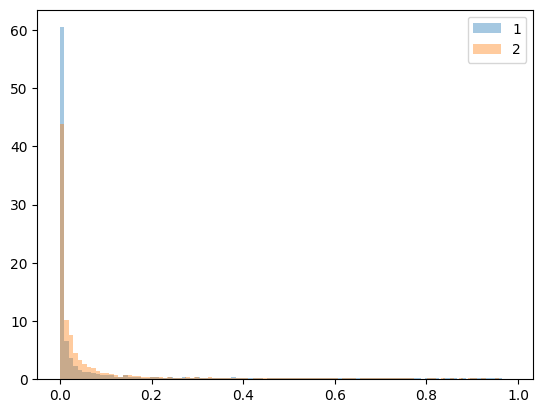

In [45]:
from matplotlib import pyplot as plt

plt.figure()
# plt.hist(predictions_test_fair, bins=100, density=True, alpha=0.4, label="plt.hist density")
plt.hist(p_test, bins=100, density=True, alpha=0.4, label="1")
plt.hist(p_test_fair, bins=100, density=True, alpha=0.4, label="2")
plt.legend()
plt.show()

In [46]:
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(S_test.columns)
    y_fair = wasserstein.transform(
        y=p_test,
        sensitive_features=S_test,
        epsilon=eps,
    )

    # "risk" / performance (use your paper's metric if different)
    mse = log_loss(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results = pd.DataFrame(rows)
print(results)

    epsilon       mse  unfairness
0       0.0  0.224260    0.149291
1       0.1  0.216584    0.102340
2       0.2  0.212256    0.086259
3       0.3  0.209283    0.138496
4       0.4  0.207137    0.192596
5       0.5  0.205602    0.247288
6       0.6  0.204577    0.302579
7       0.7  0.204020    0.357530
8       0.8  0.203931    0.411098
9       0.9  0.204358    0.466815
10      1.0  0.205429    0.524300


In [47]:
eps_grid = np.linspace(0.0, 1.0, 11)

rows = []
for e in eps_grid:
    eps = [float(e)] * len(S_test.columns)
    z_calib = logit(p_calib)
    z_test  = logit(p_test)

    # fit OT maps on logits
    maps, grid = monge_maps_fit(
        S_calib=S_calib,
        p_calib=z_calib,
        sinkhorn_reg=1e-3,        # logits often need larger reg
        sinkhorn_tol=1e-12,
        sinkhorn_maxiter=50_000,
        pad=1e-6,
        cost='l2'
        )

    z_fair = apply_fair_maps_to_test_logits(
        p_test=z_test,
        S_test=S_test,
        grid=grid,
        maps=maps,
        alpha=e,
    )

    y_fair = sigmoid(z_fair)

    # "risk" / performance (use your paper's metric if different)
    mse = log_loss(y_test, y_fair)
    # EquiPy unfairness summary (works for multi-sensitive)
    unf = unfairness(y=y_fair, sensitive_features=S_test)

    rows.append({"epsilon": e, "mse": mse, "unfairness": unf})

results_sink = pd.DataFrame(rows)
print(results_sink)

    epsilon       mse  unfairness
0       0.0  0.235838    0.139709
1       0.1  0.231311    0.089427
2       0.2  0.226993    0.088834
3       0.3  0.222912    0.114012
4       0.4  0.219107    0.135564
5       0.5  0.215625    0.159205
6       0.6  0.212522    0.222539
7       0.7  0.209870    0.293879
8       0.8  0.207746    0.367108
9       0.9  0.206237    0.447021
10      1.0  0.205429    0.524300


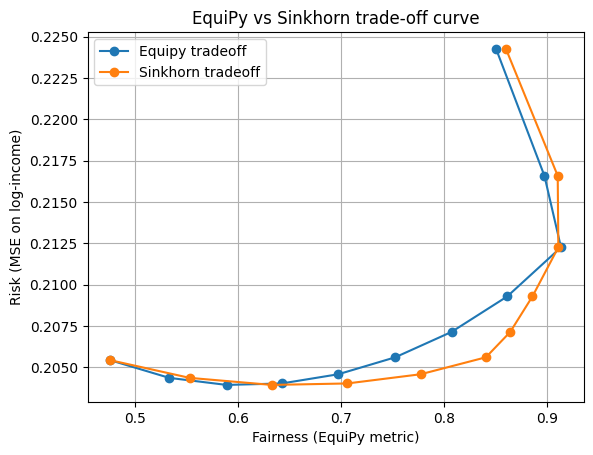


Baseline:
{'mse': 0.2054293970593681, 'Fairness': np.float64(0.5243003191122071)}


In [48]:
# -------------------------------------------------------
# 6) Simple plot: unfairness vs risk (MSE)
# -------------------------------------------------------
plt.figure()
plt.plot(1 - results["unfairness"], results["mse"], marker="o", label="Equipy tradeoff")
plt.plot(1 - results_sink["unfairness"], results["mse"], marker="o", label="Sinkhorn tradeoff")
plt.xlabel("Fairness (EquiPy metric)")
plt.ylabel("Risk (MSE on log-income)")
plt.title("EquiPy vs Sinkhorn trade-off curve")
plt.grid(True)
plt.legend()
plt.show()

# Baseline check (no post-processing):
baseline_logloss = log_loss(y_test, y_fair)
baseline_unf = unfairness(y=p_test, sensitive_features=S_test)
print("\nBaseline:")
print({"mse": baseline_logloss, "Fairness": baseline_unf})